In [1]:
import torch
import models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import Subset, DataLoader
import torchvision.transforms.functional as TF
import numpy as np
from utils import StratifiedBatchSampler
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask


Load Dataset

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean,
                          std=std)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

In [4]:
cifar_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform)

In [5]:
IDX_TO_LABEL = {v: k for k, v in cifar_dataset.class_to_idx.items()}

In [6]:
IDX_TO_LABEL

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [7]:
sampler = StratifiedBatchSampler(torch.tensor(cifar_dataset.targets), 10)

In [8]:
train_loader = DataLoader(cifar_dataset, batch_sampler=sampler, num_workers=1)

In [9]:
batch_data = next(iter(train_loader))

In [10]:
sorted_batch_lbl, indices = batch_data[1].sort()

In [11]:
sorted_batch_img = batch_data[0][indices]

In [12]:
def show_image(img):
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

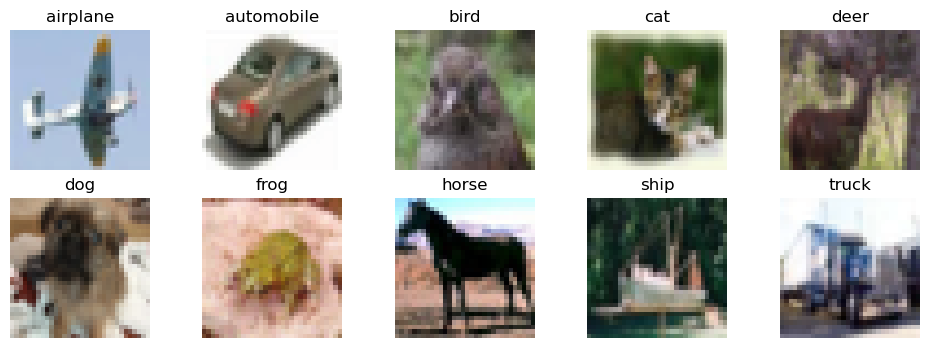

In [13]:
cols = 5
rows = 2
fig, axs = plt.subplots(rows, cols, figsize=(12,4))
smpl_idx = 0
for x in range(rows):
    for y in range(cols):
        axs[x, y].set_title(IDX_TO_LABEL[sorted_batch_lbl[smpl_idx].item()])
        axs[x, y].imshow(inv_normalize(sorted_batch_img)[smpl_idx].permute(1,2,0))
        smpl_idx += 1
        axs[x, y].set_axis_off()

plt.show()

In [14]:
moe_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Moe1_resnet32_5vK6SrW58X/ckpt.best.pth.tar')
vannila_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/log/10/resnet32-d509ac18.th')
nomoe_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Nomoe_resnet32_pOcgjojCCE/ckpt.pth.tar')
lorot_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Lorot_resnet32_nJmodpRnq5/ckpt.pth.tar')


In [15]:
class WrappedModel(torch.nn.Module):
	def __init__(self, module):
		super(WrappedModel, self).__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

In [16]:
moe_model = models.Moe1()
moe_model.load_state_dict(moe_checkpoint['state_dict'])
vannila_model = WrappedModel(models.resnet32())
vannila_model.load_state_dict(vannila_checkpoint['state_dict'])
nomoe_model = models.Nomoe()
nomoe_model.load_state_dict(nomoe_checkpoint['state_dict'])
lorot_model = models.Lorot()
lorot_model.load_state_dict(lorot_checkpoint['state_dict'])

<All keys matched successfully>

In [17]:
moe_model.eval()
vannila_model.eval()
nomoe_model.eval()
lorot_model.eval()

Lorot(
  (backbone): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2

In [18]:
moe_cam = GradCAM(moe_model, moe_model.backbone.layer3, (3,32,32))
vannila_cam = GradCAM(vannila_model, vannila_model.module.layer3, (3,32,32))
nomoe_cam = GradCAM(nomoe_model, nomoe_model.backbone.layer3, (3,32,32))
lorot_cam = GradCAM(lorot_model, lorot_model.backbone.layer3, (3,32,32))

In [19]:
def calc_grad_cam(batch_img, batch_label):
    moe_model.eval()
    vannila_model.eval()
    nomoe_model.eval()
    lorot_model.eval()

    moe_out = moe_model(batch_img)
    vannila_out = vannila_model(batch_img)
    nomoe_out = nomoe_model(batch_img)
    lorot_out = lorot_model(batch_img)

    moe_pred = moe_out.argmax(dim=1).tolist()
    vannila_pred = vannila_out.argmax(dim=1).tolist()
    nomoe_pred = nomoe_out.argmax(dim=1).tolist()
    lorot_pred = lorot_out.argmax(dim=1).tolist()

    moe_ac_map = moe_cam(moe_pred, moe_out)
    vannila_ac_map = vannila_cam(vannila_pred, vannila_out)
    nomoe_ac_map = nomoe_cam(nomoe_pred, nomoe_out)
    lorot_ac_map = lorot_cam(lorot_pred, lorot_out)
    nrows = len(batch_img)
    ncols = 5
    pad = 5
    
    col_names = ['Image', 'Vannila', 'Lorot', 'No-GSSL', 'GSSL']
    row_names = [IDX_TO_LABEL[idx.item()] for idx in batch_label]
    
    print(row_names)

    fig, axs = plt.subplots(nrows,ncols, figsize = (1.5*ncols + 1.2, 1.5*nrows))
    for ax in axs.ravel():
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, col in zip(axs[0], col_names):
        ax.set_title(col)

    for ax, row in zip(axs[:,0], row_names):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    
    batch_img = inv_normalize(batch_img)
    for i, img in enumerate(batch_img):
        axs[i,0].imshow(img.permute(1,2,0))
        axs[i,1].imshow(overlay_mask(TF.to_pil_image(img),TF.to_pil_image(vannila_ac_map[0][i].squeeze(0), mode='F'), alpha=0.7))
        axs[i,2].imshow(overlay_mask(TF.to_pil_image(img),TF.to_pil_image(lorot_ac_map[0][i].squeeze(0), mode='F'), alpha=0.7))
        axs[i,3].imshow(overlay_mask(TF.to_pil_image(img),TF.to_pil_image(nomoe_ac_map[0][i].squeeze(0), mode='F'), alpha=0.7))
        axs[i,4].imshow(overlay_mask(TF.to_pil_image(img),TF.to_pil_image(moe_ac_map[0][i].squeeze(0), mode='F'), alpha=0.7))
    fig.tight_layout()
    plt.show()
        
    

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


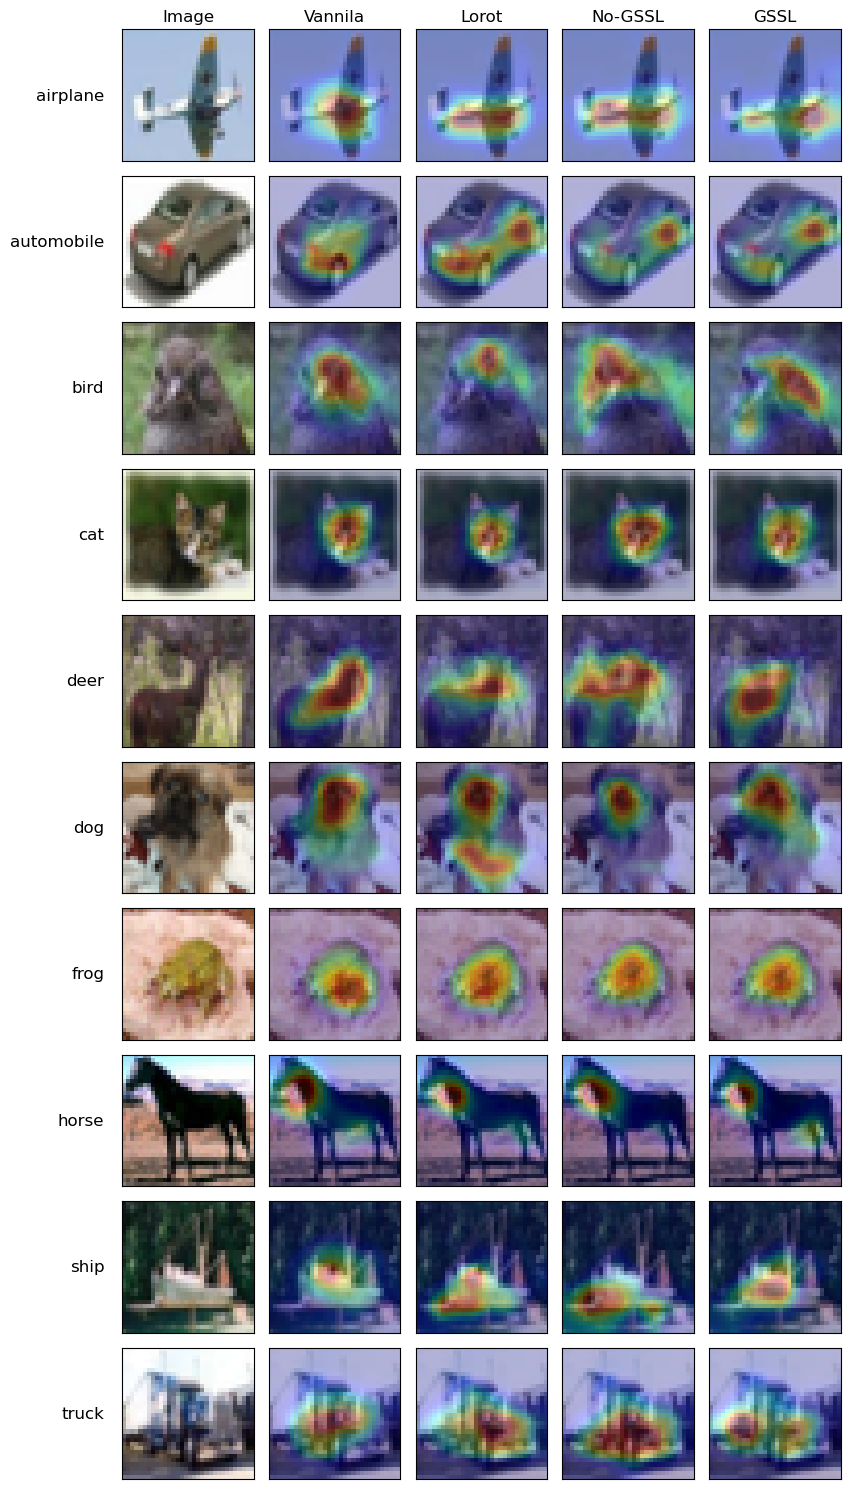

In [20]:
calc_grad_cam(sorted_batch_img, sorted_batch_lbl)